In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        action_probs = np.full((nA,),epsilon/nA)
        max_action = np.argmax(Q[observation])
        action_probs[max_action] = 1 - epsilon + epsilon/nA
        return action_probs
        
    return policy_fn

In [13]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    def run_episode(policy):
        observations, actions, rewards = [], [], []
        observation = env.reset()
        while True:
            action = np.random.choice(range(env.action_space.n),p=policy(observation))#np.argmax(policy(observation))
            next_observation, reward, done, _ = env.step(action)
            
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            
            observation = next_observation
            
            if done:
                break
        
        return observations, actions, rewards
    
    def calculate_return(t, rewards):
        T = len(rewards) 
        return np.sum([discount_factor**(k-t)*rewards[k] for k in range(t,T)])

    def print_observation(observation):
        score, dealer_score, usable_ace = observation
        print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
              score, usable_ace, dealer_score))
    
    def print_transitions(observations, rewards, actions):
        for obs, r, action in zip(observations, rewards, actions):
            print()
            print_observation(obs)
            print("Action: {}".format(action))
            print("Reward: {}\n".format(r))
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for eps in range(num_episodes):
        if eps % 1000 == 0:
            print("\rEpisode {}/{}.".format(eps, num_episodes), end="")
            sys.stdout.flush()
            
        observations, actions, rewards = run_episode(policy)
        #print_transitions(observations, rewards, actions)
    
        state_actions_in_episode = set([(tuple(obs),action) for obs, action in zip(observations,actions)])
        for state, action in state_actions_in_episode:
            state_action = (state, action)
            #print("state_action: ",state_action)
            #print("state: {}, action: {}".format(state,action))
            first_occurrence_idx = next(t for t, s_a in enumerate(zip(observations,actions)) if s_a == state_action)
            #print("first_occurrence_idx: ",first_occurrence_idx)
            G = calculate_return(first_occurrence_idx, rewards)
            returns_sum[(state,action)] += G
            returns_count[(state,action)] += 1
            Q[state][action] = returns_sum[(state,action)] / returns_count[(state,action)]
            #print("Q[{}][{}]: {}".format(state,action,Q[state][action]))
    
    return Q, policy

In [11]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

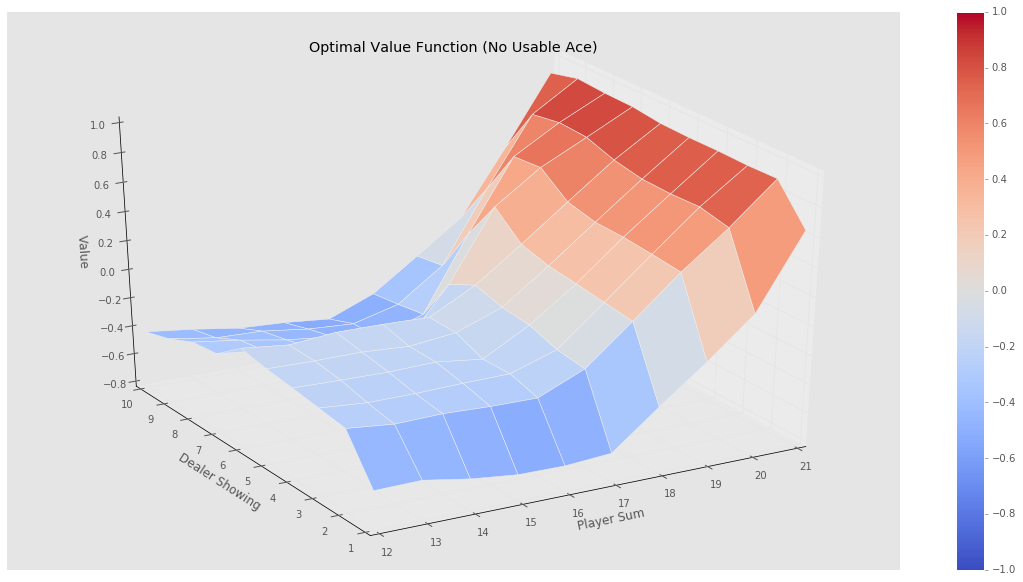

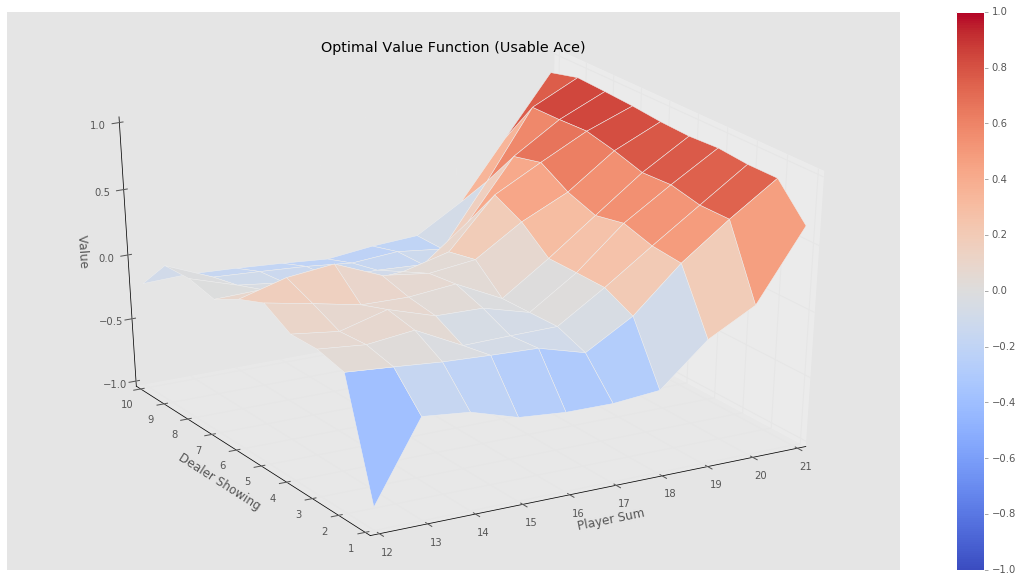

In [12]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")